In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from dataclasses import dataclass
from pandas import Series
from scipy.stats import norm, cumfreq


@dataclass
class RSI:
    closes: Series
    period: int = 14

    def __post_init__(self) -> None:
        self.data: Series = self.get_rsi()

    def get_rsi(self) -> Series:
        delta = self.closes.diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        ema_up = up.ewm(com=self.period - 1 if self.period >
                        0 else 0, adjust=False).mean()
        ema_down = down.ewm(com=self.period - 1 if self.period >
                            0 else 0, adjust=False).mean()
        rs = ema_up / ema_down
        rsi = 100 - (100 / (1 + rs))
        rsi[:15] = None
        return rsi

@dataclass
class MACD:
    adj_closes: Series
    slow_length: int = 26
    fast_length: int = 12
    signal_smoothing: int = 9

    def __post_init__(self):
        self.data = self.get_macd()

    def get_macd(self):
        fast_ema = self.adj_closes.ewm(span=self.fast_length).mean()
        slow_ema = self.adj_closes.ewm(span=self.slow_length).mean()
        macd = (slow_ema - fast_ema) * -1
        macd_signal_line = macd.ewm(span=self.signal_smoothing).mean()
        histogram = macd - macd_signal_line
        return macd, macd_signal_line, histogram


In [2]:
df = yf.download("AAPL", interval='1d', period='2y')
rsi = RSI(df['Close']).data
macd, macd_signal, macd_histogram = MACD(df['Close']).data

df["MACD"] = macd_histogram
df['RSI'] = rsi

[*********************100%***********************]  1 of 1 completed


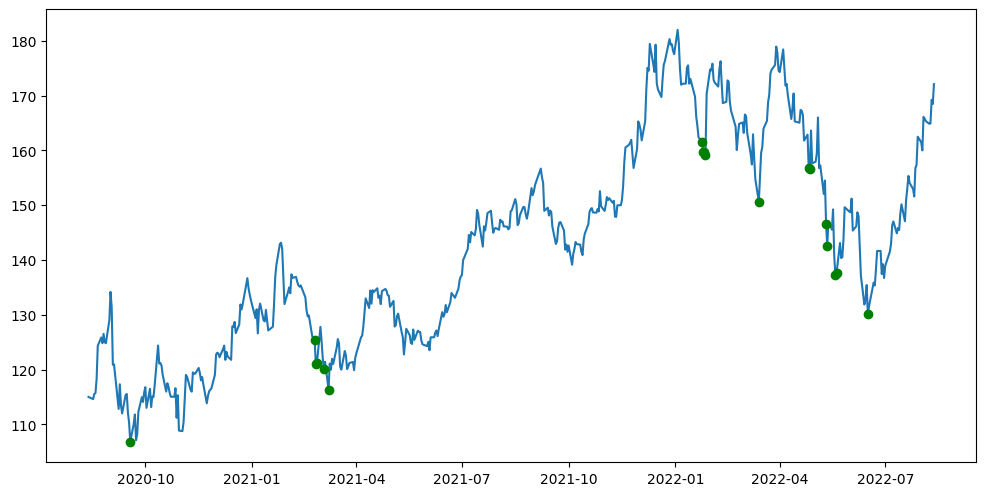

In [3]:
entries = df[(df['RSI'] < 35) & (df['MACD'] < -1)]

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(df.index, df['Close'], label="PRICE")

for entry in entries.index:
    plt.plot(entry, df.loc[entry]['Close'], marker='o', c='g')

In [4]:
# Case One (Randomly placed values AND positive last nth values)
a = [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1]
b = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]

# Case two (Alternated truthy values AND positive last nth values)
c = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
d = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

# Case Three (Positive array) MAX FREQUENCY
e = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 


# Case Four (Negative Array) MIN FREQUENCY
f = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Case Five (Positive first nth values AND negative last nth values) ASSERT -> EQUAL
g = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
h = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

In [5]:

def get_previous_truthy_value(arr: list[bool | int], i: int):
    sub_arr = arr[:i]

    for n, val in enumerate(sub_arr[::-1]):
        if val:
            return i - n -1 

get_previous_truthy_value(a, 5)

1

In [6]:
def evaluate_falsy_spans(arr: list[int | bool]):
    spans = []
    for i, val in enumerate(arr):
        previous_value = get_previous_truthy_value(arr, i)
        if val:
            if not previous_value:
                if i == 0:
                    spans.append(0)
                else:
                    if previous_value == 0:
                        spans.append(len(arr[previous_value + 1:i]))
                    else:
                        spans.append(len(arr[previous_value:i]))
            else:
                spans.append(len(arr[previous_value + 1: i]))
    return spans

In [22]:
def print_spans(arr):
    print("Array: ", arr)
    print("Falsy-spans: ", evaluate_falsy_spans(arr), "\n")


In [25]:
print_spans(a)
print_spans(b)
print_spans(c)
print_spans(d)
print_spans(e)
print_spans(f)
print_spans(g)
print_spans(h)

Array:  [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1]
Falsy-spans:  [1, 3, 2, 1] 

Array:  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Falsy-spans:  [7, 0, 0, 0] 

Array:  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
Falsy-spans:  [1, 1, 1, 1, 1] 

Array:  [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Falsy-spans:  [5, 0, 0, 0, 0] 

Array:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Falsy-spans:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

Array:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Falsy-spans:  [] 

Array:  [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Falsy-spans:  [5, 0, 0, 0, 0] 

Array:  [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Falsy-spans:  [0, 0, 0, 0, 0] 

